###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 2: How Long Will It Take To Cook This?

###### Submission deadline: 5 pm, Friday 21 May 2021

# Import

In [1]:
# Basic Import
import pandas as pd; import numpy as np
# Import Sklearn
from sklearn.model_selection import train_test_split as tts, GridSearchCV as gs, validation_curve as vc, learning_curve as lc
from sklearn.feature_extraction.text import TfidfVectorizer as tv; from sklearn.svm import LinearSVC as lsvc
from sklearn.pipeline import Pipeline as pl; from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.feature_selection import SelectKBest as skb
# Import plotting
import matplotlib.pyplot as plt; 

# Load Dataset

In [2]:
#pre-data for later work
raw_data = pd.read_csv('COMP30027_2021_Project2_datasets/recipe_train.csv')
test_data = pd.read_csv('COMP30027_2021_Project2_datasets/recipe_test.csv')

# Preprocess

In [3]:
def preprocess(training_data):
    """This function make the data become readable and more easy to be trained"""
    # Make a copy
    copy = training_data.copy(deep=True)
    # Make data become original type of dataset without number or other non-characters
    copy['steps'] = copy['steps'].apply(eval).apply(" ".join).str.replace("[^a-zA-Z#]", " ")
    
    return copy

# Train

In [4]:
def train(training_data):
    """This function train our raw data by several models and for later predicting use"""
    # Normal training
    x_train, x_dev, y_train, y_dev = tts(training_data.drop(columns='duration_label'), training_data['duration_label'], test_size=0.25, random_state=59)
    # Clean our data for better performance
    tfi = tv(stop_words='english').fit(x_train['steps'])
    x_train_steps_tv = tfi.transform(x_train['steps']); x_dev_steps_tv = tfi.transform(x_dev['steps'])
    # A dictionary collects trained data
    trained = {}
    trained['normal'] = [x_train, x_dev, y_train, y_dev]
    trained['tv'] = [x_train_steps_tv, x_dev_steps_tv, y_train, y_dev]

    return trained

# Evaluate

## Model 1 -- Linear SVC

In [5]:
# Pipeline used for the grid-search (LinearSVC)
pipeline_svc = pl(
    [
        ('kbest', skb()), ('svc', lsvc(max_iter=1000))
    ]
)
# Parameters are the changing value to find the optimal solution (LinearSVC)
parameters_svc = {
    'svc__C': (0.01, 0.1, 0.3, 0.5, 1, 10),
    'kbest__k': (4000, 6000, 8000, 10000, 'all')
}

## Model 2 -- DecisionTree

In [6]:
# Pipeline used for the grid-search (DecisionTre)
pipeline_dt = pl(
    [
        ('kbest', skb()), ('tree', dt())
    ]
)
# Parameters are the changing value to find the optimal solution (DecisionTre)
parameters_dt = {
    'kbest__k': (4000, 6000, 8000, 10000, 'all'),
    'tree__max_depth': (4, 5, 6, 7, 8, 9)
}

# Evaluate by Grid-Search

In [7]:
def evaluate(pipeline, parameters, x, y):
    """This function is using grid-search method and sent out the best 5 result"""
    grs = gs(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)

    # To see the overall data and print out top 5
    grs.fit(x, y)
    mean_score = grs.cv_results_['mean_test_score']
    param_set = grs.cv_results_['params']
    for idx in mean_score.argsort()[-5:]:
        print(param_set[idx])
        print(grs.cv_results_['mean_test_score'][idx])
        print("="*30)

    return grs

# Implement

In [8]:
# Make a trained data for making model purpose
trained = train(preprocess(raw_data))

<ipython-input-3-f229fe9011d0>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  copy['steps'] = copy['steps'].apply(eval).apply(" ".join).str.replace("[^a-zA-Z#]", " ")


## Do LinearSVC - TFIDF

In [9]:
lsvc_tv = evaluate(pipeline_svc, parameters_svc, trained['tv'][0], trained['tv'][2])

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'kbest__k': 4000, 'svc__C': 0.1}
0.7606333333333334
{'kbest__k': 6000, 'svc__C': 0.1}
0.7607999999999999
{'kbest__k': 'all', 'svc__C': 0.1}
0.7609666666666667
{'kbest__k': 8000, 'svc__C': 0.1}
0.7609999999999999
{'kbest__k': 10000, 'svc__C': 0.1}
0.7611333333333333


## Do DecisionTree - TFIDF

In [10]:
dt_tv = evaluate(pipeline_dt, parameters_dt, trained['tv'][0], trained['tv'][2])

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'kbest__k': 'all', 'tree__max_depth': 9}
0.7301333333333333
{'kbest__k': 10000, 'tree__max_depth': 9}
0.7301666666666666
{'kbest__k': 4000, 'tree__max_depth': 9}
0.7301666666666666
{'kbest__k': 'all', 'tree__max_depth': 7}
0.7303333333333333
{'kbest__k': 8000, 'tree__max_depth': 9}
0.7305666666666666


# Found The Best

## LinearSVC - Validate Curve

In [11]:
kbest_lsvc = skb(k=10000).fit(trained['tv'][0], trained['tv'][2]); train_steps_bestK_lsvc = kbest_lsvc.transform(trained['tv'][0]); param_range = np.logspace(-2, 2, 10)
# Validate the LinearSVC and get the score for visualising the trend between accuracy and parameter C
train_scores_lsvc, validation_scores_lsvc = vc(lsvc(max_iter=1000, C=0.1), train_steps_bestK_lsvc, trained['tv'][2], param_name="C", param_range=param_range, cv=5, n_jobs=-1, verbose=-1)

scores_lsvc = [np.mean(train_scores_lsvc, axis=1), np.std(train_scores_lsvc, axis=1), np.mean(validation_scores_lsvc, axis=1), np.std(validation_scores_lsvc, axis=1)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  50 | elapsed:    0.7s remaining:   20.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.3s finished


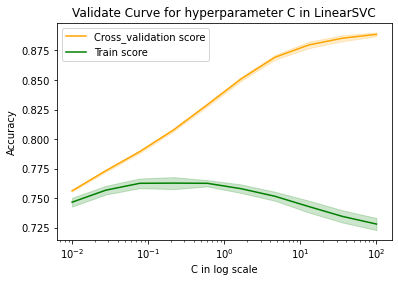

In [12]:
plt.semilogx(param_range, scores_lsvc[0], label="Cross_validation score", color='orange')
plt.fill_between(param_range, scores_lsvc[0] - scores_lsvc[1], scores_lsvc[0] + scores_lsvc[1], alpha=0.2, color='orange')
plt.semilogx(param_range, scores_lsvc[2], label="Train score", color='g')
plt.fill_between(param_range, scores_lsvc[2] - scores_lsvc[3], scores_lsvc[2] + scores_lsvc[3], alpha=0.2, color='g')
plt.legend(loc='best')
plt.title("Validate Curve for hyperparameter C in LinearSVC"); plt.xlabel("C in log scale"); plt.ylabel("Accuracy")
plt.show()

## DecisionTree - Learning Curve

In [13]:
kbest_dt = skb(k='all').fit(trained['tv'][1], trained['tv'][3]); train_steps_bestK_dt = kbest_dt.transform(trained['tv'][0])
# Validate the DecisionTree and get the score for visualising the trend between accuracy and parameter max_depth
train_size, train_scores_dt, validation_scores_dt = lc(dt(random_state=100, max_depth=9), train_steps_bestK_dt, trained['normal'][2], train_sizes=np.linspace(0.1, 1, 5), cv=5, n_jobs=-1, verbose=-1)

scores_dt = [np.mean(train_scores_dt, axis=1), np.std(train_scores_dt, axis=1), np.mean(validation_scores_dt, axis=1), np.std(validation_scores_dt, axis=1)]

C:\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:    0.5s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.5s finished


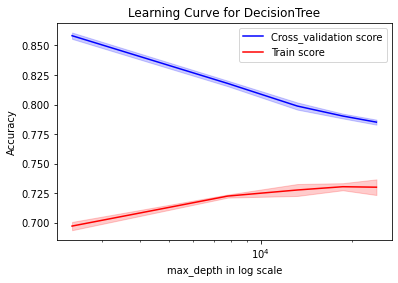

In [14]:
plt.semilogx(train_size, scores_dt[0], label="Cross_validation score", color='blue')
plt.fill_between(train_size, scores_dt[0] - scores_dt[1], scores_dt[0] + scores_dt[1], alpha=0.2, color='blue')
plt.semilogx(train_size, scores_dt[2], label="Train score", color='r')
plt.fill_between(train_size, scores_dt[2] - scores_dt[3], scores_dt[2] + scores_dt[3], alpha=0.2, color='r')
plt.legend(loc='best')
plt.title("Learning Curve for DecisionTree"); plt.xlabel("max_depth in log scale"); plt.ylabel("Accuracy")
plt.show()

# Predict Data

In [15]:
test = preprocess(test_data)
tfi_test = tv(stop_words='english').fit(trained['normal'][0]['steps'])
x_test_tv = tfi_test.transform(test['steps'])

<ipython-input-3-f229fe9011d0>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  copy['steps'] = copy['steps'].apply(eval).apply(" ".join).str.replace("[^a-zA-Z#]", " ")


In [16]:
pipe_lsvc = pl([('kbest', skb(k=10000)), ('svc', lsvc(C=0.1, max_iter=1000, verbose=-1))])
pipe_lsvc.fit(trained['tv'][0], trained['tv'][2]); prediction_lsvc = pipe_lsvc.predict(x_test_tv)
df_lsvc = pd.DataFrame()
index = [i for i in range(1, trained['tv'][1].shape[0] + 1)]
df_lsvc['id'] = index
df_lsvc['duration_label'] = prediction_lsvc
df_lsvc.to_csv("predict_lsvc.csv", index=False)

[LibLinear]

In [17]:
pipe_dt = pl([('kbest', skb(k='all')), ('dt', dt(random_state=100, max_depth=9))])
pipe_dt.fit(trained['tv'][0], trained['tv'][2]); prediction_dt = pipe_dt.predict(x_test_tv)
df_dt = pd.DataFrame()
index = [i for i in range(1, trained['tv'][1].shape[0] + 1)]
df_dt['id'] = index
df_dt['duration_label'] = prediction_dt
df_dt.to_csv("predict_dt.csv", index=False)